In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [8]:
device = torch.device('cuda:0')
torch.set_default_device(device)

In [9]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [10]:
len(words)

32033

In [11]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [12]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [15]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer 
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2845
  10000/ 200000: 1.9122
  20000/ 200000: 2.3562
  30000/ 200000: 2.3121
  40000/ 200000: 1.9093
  50000/ 200000: 2.2561
  60000/ 200000: 1.9132
  70000/ 200000: 2.1371
  80000/ 200000: 1.9628
  90000/ 200000: 2.0821
 100000/ 200000: 2.8121
 110000/ 200000: 2.1500
 120000/ 200000: 2.1172
 130000/ 200000: 1.7909
 140000/ 200000: 2.1843
 150000/ 200000: 2.3734
 160000/ 200000: 2.1425
 170000/ 200000: 2.0303
 180000/ 200000: 2.1065
 190000/ 200000: 2.1415


In [18]:
h.shape

torch.Size([32, 200])

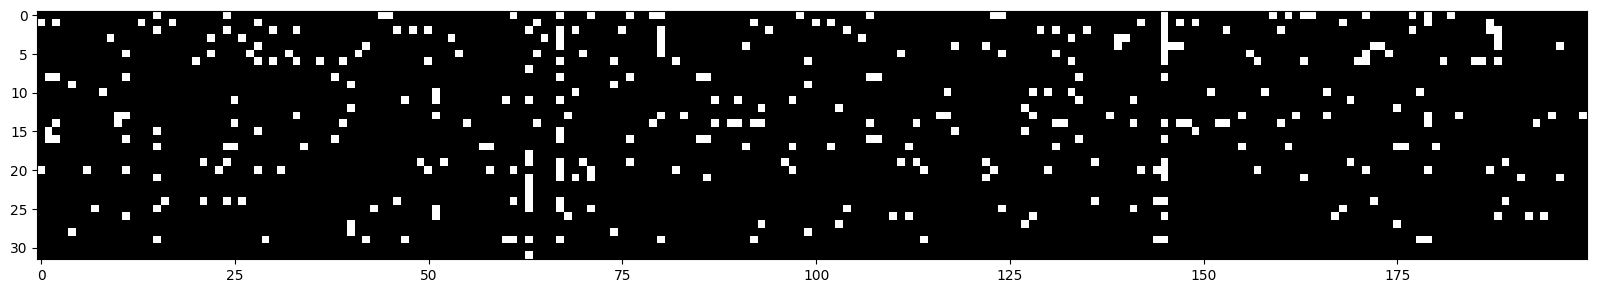

In [25]:
plt.figure(figsize=(20,10))
plt.imshow(h.cpu().abs() > 0.99, cmap='gray', interpolation='nearest')

(array([485., 224., 170., 152., 132., 116., 104., 118., 113., 117., 113.,
         88., 100.,  81., 114.,  71.,  91., 120., 102.,  82.,  81.,  93.,
         82., 105., 142.,  99., 113., 120., 115., 117., 123., 108.,  77.,
        112., 126.,  83.,  94.,  76.,  78.,  79.,  92., 114.,  83., 119.,
        136., 139., 142., 171., 250., 438.]),
 array([-9.99975026e-01, -9.59975529e-01, -9.19976032e-01, -8.79976535e-01,
        -8.39977038e-01, -7.99977541e-01, -7.59978044e-01, -7.19978547e-01,
        -6.79979050e-01, -6.39979553e-01, -5.99980056e-01, -5.59980559e-01,
        -5.19981062e-01, -4.79981565e-01, -4.39982069e-01, -3.99982572e-01,
        -3.59983075e-01, -3.19983578e-01, -2.79984081e-01, -2.39984584e-01,
        -1.99985087e-01, -1.59985590e-01, -1.19986093e-01, -7.99865961e-02,
        -3.99870992e-02,  1.23977661e-05,  4.00118947e-02,  8.00113916e-02,
         1.20010889e-01,  1.60010386e-01,  2.00009882e-01,  2.40009379e-01,
         2.80008876e-01,  3.20008373e-01,  3.60007

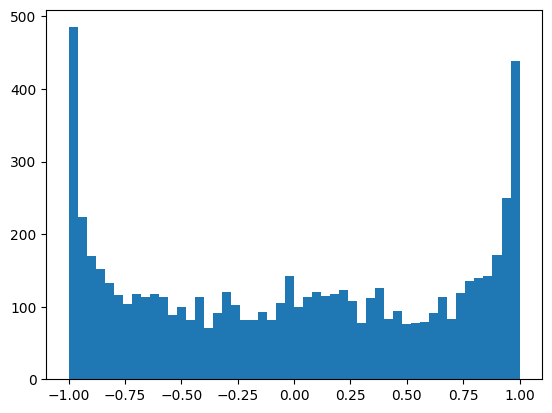

In [20]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   0.,   0.,   4.,   6.,   7.,   7.,  21.,  26.,  58.,  59.,
         97., 132., 171., 187., 244., 303., 424., 507., 589., 758., 701.,
        419., 377., 325., 237., 221., 148., 110.,  74.,  56.,  51.,  25.,
         20.,  13.,   9.,   3.,   2.,   0.,   3.,   0.,   1.,   0.,   1.,
          1.,   0.,   0.,   0.,   1.,   1.]),
 array([-5.6448369 , -5.36910012, -5.09336334, -4.81762656, -4.54188978,
        -4.266153  , -3.99041622, -3.71467944, -3.43894266, -3.16320588,
        -2.8874691 , -2.61173232, -2.33599554, -2.06025876, -1.78452198,
        -1.5087852 , -1.23304842, -0.95731164, -0.68157486, -0.40583808,
        -0.1301013 ,  0.14563548,  0.42137226,  0.69710904,  0.97284582,
         1.2485826 ,  1.52431938,  1.80005616,  2.07579294,  2.35152972,
         2.6272665 ,  2.90300328,  3.17874006,  3.45447684,  3.73021362,
         4.0059504 ,  4.28168718,  4.55742396,  4.83316074,  5.10889752,
         5.3846343 ,  5.66037108,  5.93610786,  6.21184464,  6.48758142,
 

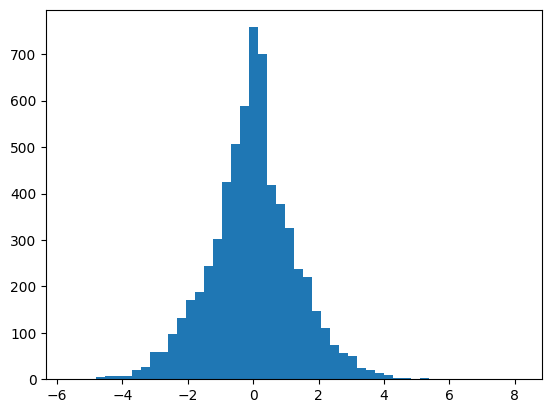

In [21]:
plt.hist(hpreact.view(-1).tolist(), 50)

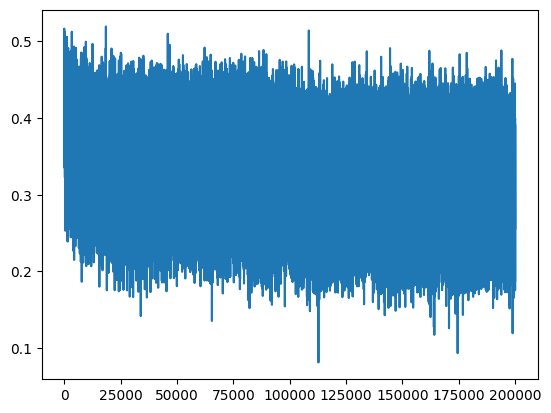

In [16]:
plt.plot(lossi)

In [17]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0690019130706787
val 2.1123876571655273
